Using padded data, additional values added 

In [172]:
import os
import h5py
from scipy.io import loadmat
import numpy as np
import random
from preproc import *
from itertools import combinations 
from scipy.special import factorial
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from matplotlib.widgets import Slider
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, ClassifierMixin
import textwrap
import pickle

In [107]:
# Choose which days to include
#day_list = ['20181105', '20181102', '20181101']

# Or, read in list of days from txt file
day_list = list()
with open(f'data/combined/days.txt', 'r') as file:
    for line in file:
        day_list.append(line.strip())

num_sess = len(day_list)
num_goals = 6
tbin_size = 0.1

In [108]:
good_cell_labels = list()
with open('data/cell_list_hm.txt', 'r') as file:
    for line in file:
        line = line.strip().split('/')
        good_cell_labels.append(f'{line[5]}ch{str(int(line[8][7:]))}c{str(int(line[9][4:]))}')
print(good_cell_labels)

['20181105ch29c1', '20181105ch30c1', '20181105ch43c1', '20181105ch43c2', '20181105ch43c3', '20181105ch45c1', '20181102ch9c1', '20181102ch19c1', '20181102ch19c2', '20181102ch26c1', '20181102ch26c2', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c1', '20181102ch43c2', '20181102ch45c1', '20181102ch45c2', '20181101ch19c1', '20181101ch19c2', '20181101ch21c1', '20181101ch23c1', '20181101ch29c1', '20181101ch29c2', '20181101ch29c3', '20181101ch29c4', '20181101ch30c1', '20181101ch30c2', '20181101ch35c1', '20181101ch43c1', '20181101ch45c1', '20181031ch19c1', '20181031ch19c2', '20181031ch19c3', '20181031ch26c1', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch30c2', '20181031ch35c1', '20181031ch35c2', '20181031ch35c3', '20181031ch43c1', '20181031ch43c2', '20181031ch45c1', '20181031ch45c2', '20181026ch19c1', '20181026ch19c2', '20181026ch19c3', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch35c3', '20181026c

In [109]:
# Save directory for data files
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
save_dir = "data/placedist"
# Whether to overwrite preexisting files
overwrite = True

In [110]:
#Read placeist files
all_place_responses = list()
all_place_durations = list()
all_cell_labels = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        num_sess_cells = len(data['cell_labels'])
        all_place_responses.extend(data['place_responses_per_cell'])
        for _ in range(num_sess_cells):
            all_place_durations.append(data['durations_per_place'])
        all_cell_labels.extend(data['cell_labels'])

In [111]:
del all_place_durations
del all_place_responses

In [112]:
new_list_labels = list()
for cell_label in all_cell_labels:
    if cell_label in good_cell_labels:
        new_list_labels.append(cell_label)
print(len(new_list_labels))

364


In [143]:
# Set amount of bins, see which cells are valid for testing 
total_bins = 23
two_thirds = 16
valid_cells_distribution = list()

for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in good_cell_labels:
            continue
        total_valid_bins = list()
        # if 2/3 of the bins contain over 30 samples, the cell is valid
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if dist.size > 30:
                total_valid_bins.append(bin)

        if len(total_valid_bins) > two_thirds:
            valid_cells_distribution.append(label)
print('Amount of valid cells:', len(valid_cells_distribution))
train_size = int(round((len(valid_cells_distribution) * 0.7),0))
test_size = int(round((len(valid_cells_distribution) * 0.3),0))
print(train_size)
print(test_size)
print(valid_cells_distribution)
list_nums = list(range(1,224))
valid_cell_to_num = dict(zip(valid_cells_distribution, list_nums))
print(valid_cell_to_num)


Amount of valid cells: 223
156
67
['20181105ch43c1', '20181105ch43c3', '20181105ch45c1', '20181102ch19c1', '20181102ch29c1', '20181102ch30c1', '20181102ch30c2', '20181102ch31c1', '20181102ch43c2', '20181101ch19c1', '20181101ch21c1', '20181101ch29c3', '20181101ch29c4', '20181101ch30c2', '20181101ch43c1', '20181031ch19c2', '20181031ch26c2', '20181031ch29c1', '20181031ch30c1', '20181031ch43c1', '20181031ch43c2', '20181026ch19c1', '20181026ch29c1', '20181026ch30c1', '20181026ch35c1', '20181026ch35c2', '20181026ch45c1', '20181022ch9c1', '20181022ch26c1', '20181022ch29c1', '20181022ch43c1', '20181022ch43c4', '20181022ch45c1', '20181017ch29c1', '20181017ch45c1', '20181016ch20c1', '20181016ch29c1', '20181016ch45c1', '20181015ch20c1', '20181015ch29c1', '20181015ch45c1', '20181011ch20c1', '20181011ch29c1', '20181011ch45c1', '20181011ch45c2', '20181010ch45c1', '20181009ch45c1', '20181009ch45c4', '20181005ch45c4', '20181005ch45c1', '20181005ch45c2', '20181005ch45c3', '20181004ch45c1', '20181004ch4

In [114]:
# Sample separation into train and test sets 
list_train = random.sample(valid_cells_distribution, train_size)
list_test = random.sample(valid_cells_distribution, test_size)
print(list_train)
print(list_test)


['20180905ch29c1', '20181022ch43c4', '20181005ch45c1', '20180710ch86c1', '20180823ch21c1', '20180919ch29c1', '20181105ch45c1', '20180828ch93c1', '20180918ch20c1', '20180910ch29c1', '20181101ch19c1', '20180827ch21c1', '20180904ch38c1', '20180912ch21c1', '20180920ch29c1', '20181009ch45c4', '20181016ch20c1', '20181004ch45c1', '20180918ch34c1', '20181105ch43c3', '20180829ch45c3', '20180925ch29c1', '20180817ch59c1', '20180807ch86c4', '20180702ch26c1', '20180823ch20c1', '20180813ch45c1', '20180810ch86c2', '20180719ch86c2', '20180829ch93c1', '20180801ch86c2', '20180905ch21c1', '20180928ch45c1', '20180814ch45c2', '20180829ch38c2', '20180905ch20c2', '20180706ch86c2', '20180705ch86c1', '20180725ch43c1', '20180725ch86c1', '20180903ch20c1', '20181005ch45c4', '20180810ch21c2', '20180907ch29c1', '20180706ch86c1', '20180810ch30c1', '20181015ch20c1', '20180814ch21c1', '20180726ch86c1', '20180914ch21c1', '20180731ch86c2', '20180912ch29c1', '20181017ch29c1', '20180827ch45c1', '20180920ch29c2', '20180718

In [115]:
bins_data = {}
for day in day_list:
    with open(f'{save_dir}/{day}_data.pkl', 'rb') as file:
        data = pickle.load(file)
        place_responses_per_cell = data['place_responses_per_cell']
        cell_labels = data['cell_labels']
    for cell, label in enumerate(cell_labels):
        if label not in valid_cells_distribution:
            continue
        for bin, dist in place_responses_per_cell[cell].items():
            dist = dist[dist > 0]
            if bin not in bins_data:
                bins_data[bin] = []
            bins_data[bin].append(dist)


In [116]:
# Example Bin data:
if 3 in bins_data:
    print(f"Distributions for bin 3: {bins_data[3]}")
else:
    print("Bin 3 not found in data.")

Distributions for bin 3: [array([ 1.33127647,  1.78560001,  2.20236366,  2.45816459,  2.77010005,
        2.90036353,  3.1392857 ,  3.23590573,  3.37839474,  3.67603129,
        3.73058175,  3.78720302,  3.84619531,  3.87391643,  3.92138237,
        3.95320666,  4.00032271,  4.04915817,  4.06407947,  4.13254325,
        4.34675766,  4.4647608 ,  4.50200916,  4.54071041,  4.58688081,
        4.76060139,  4.78392062,  4.80568339,  4.8077766 ,  4.83248427,
        4.83598118,  4.84933298,  4.87921451,  4.90181753,  4.94937793,
        4.95094525,  4.97455151,  5.01222744,  5.12757472,  5.17975252,
        5.18058405,  5.23147358,  5.23395528,  5.23411088,  5.26225676,
        5.26317698,  5.31887953,  5.34646545,  5.36164566,  5.37460149,
        5.37477298,  5.46328201,  5.46499599,  5.49088395,  5.49396865,
        5.52246775,  5.52429457,  5.74505001,  5.8136583 ,  5.8452725 ,
        5.84864188,  5.84891781,  5.84938162,  5.86417797,  5.91510262,
        5.94975729,  5.95940714,  5.98

In [129]:
X = []
y = []
bin_list = [1,2,3,4,5,6,8,10,11,12,13,14,15,16,18,20,21,22,23,24,25]
for i in bin_list:
    temp_list = bins_data[i]
    X.extend(temp_list)
    y.extend([i] * len(bins_data[i]))


In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [133]:
max_length = max(len(seq) for seq in X)
X_padded = pad_sequences(X, maxlen=max_length, padding='post', dtype='float32')
y = np.asarray(y)
    

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
accuracy_random_forst = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

Accuracy: 0.2550693703308431
Classification Report:
              precision    recall  f1-score   support

           1       0.23      0.20      0.21        56
           2       0.10      0.11      0.11        45
           3       0.28      0.28      0.28        47
           4       0.27      0.25      0.26        44
           5       0.31      0.43      0.36        46
           6       0.21      0.24      0.23        45
           8       0.48      0.23      0.31        53
          10       0.12      0.12      0.12        42
          11       0.12      0.08      0.10        48
          12       0.32      0.44      0.37        34
          13       0.75      0.77      0.76        43
          14       0.34      0.35      0.34        43
          15       0.19      0.24      0.21        38
          16       0.18      0.23      0.20        39
          18       0.26      0.21      0.23        53
          20       0.14      0.14      0.14        37
          21       0.27      

In [156]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
mse_random_forest_regressor = mean_squared_error(y_test, y_pred)


Mean Squared Error: 62.73197150480256


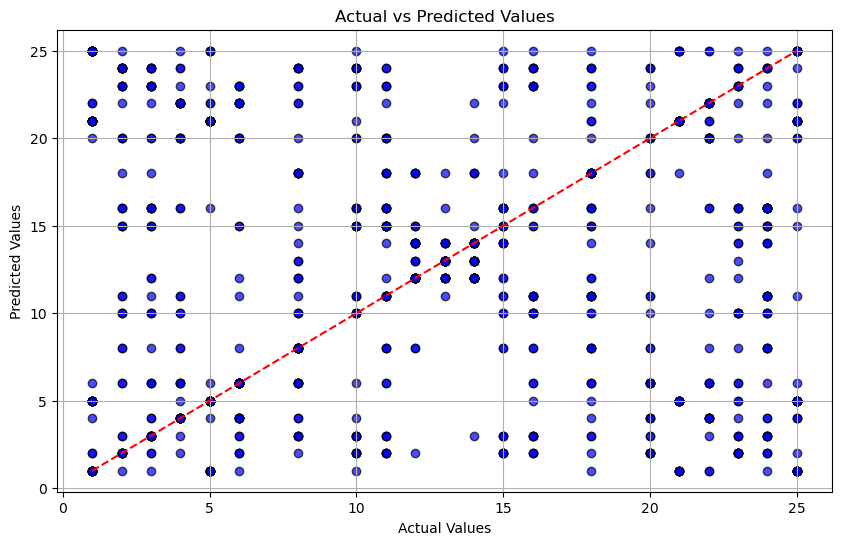

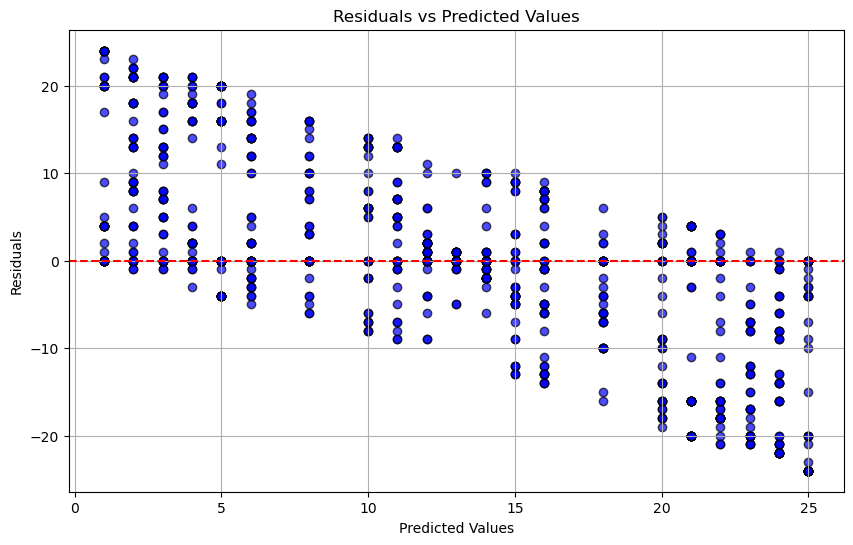

In [159]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()

In [174]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_decision_tree_classifier = accuracy_score(y_test, y_pred)
print(accuracy_decision_tree_classifier)
eport = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")

0.2209178228388474
Classification Report:
              precision    recall  f1-score   support

           1       0.23      0.20      0.21        56
           2       0.10      0.11      0.11        45
           3       0.28      0.28      0.28        47
           4       0.27      0.25      0.26        44
           5       0.31      0.43      0.36        46
           6       0.21      0.24      0.23        45
           8       0.48      0.23      0.31        53
          10       0.12      0.12      0.12        42
          11       0.12      0.08      0.10        48
          12       0.32      0.44      0.37        34
          13       0.75      0.77      0.76        43
          14       0.34      0.35      0.34        43
          15       0.19      0.24      0.21        38
          16       0.18      0.23      0.20        39
          18       0.26      0.21      0.23        53
          20       0.14      0.14      0.14        37
          21       0.27      0.46      

In [162]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC(kernel='poly')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
print()

Accuracy Score: 0.1814300960512273
Classification Report:
              precision    recall  f1-score   support

           1       0.32      0.34      0.33        56
           2       0.06      0.07      0.06        45
           3       0.21      0.23      0.22        47
           4       0.19      0.23      0.20        44
           5       0.24      0.28      0.26        46
           6       0.13      0.13      0.13        45
           8       0.08      0.08      0.08        53
          10       0.10      0.10      0.10        42
          11       0.18      0.19      0.18        48
          12       0.31      0.44      0.36        34
          13       0.43      0.35      0.38        43
          14       0.40      0.33      0.36        43
          15       0.07      0.08      0.07        38
          16       0.06      0.08      0.07        39
          18       0.14      0.11      0.12        53
          20       0.05      0.05      0.05        37
          21       0.24

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.22, random_state=42)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.14161008729388944
Classification Report:
              precision    recall  f1-score   support

           1       0.22      0.26      0.24        57
           2       0.00      0.00      0.00        50
           3       0.06      0.06      0.06        53
           4       0.23      0.17      0.20        52
           5       0.23      0.31      0.26        49
           6       0.12      0.14      0.13        51
           8       0.23      0.11      0.14        57
          10       0.04      0.07      0.05        45
          11       0.09      0.06      0.07        49
          12       0.22      0.16      0.19        37
          13       0.34      0.29      0.31        49
          14       0.14      0.11      0.12        45
          15       0.06      0.05      0.05        43
          16       0.09      0.15      0.11        48
          18       0.15      0.09      0.11        57
          20       0.12      0.10      0.11        39
          21       0.26     

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='linear', probability=True, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
lda = LinearDiscriminantAnalysis()

models = {
    'Random Forest': rf,
    'SVM': svm,
    'Decision Tree': dt,
    'LDA': lda
}

rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
dt.fit(X_train, y_train)
lda.fit(X_train, y_train)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")

Random Forest Accuracy: 0.2550693703308431
Random Forest Classification Report:
              precision    recall  f1-score   support

           1       0.23      0.20      0.21        56
           2       0.10      0.11      0.11        45
           3       0.28      0.28      0.28        47
           4       0.27      0.25      0.26        44
           5       0.31      0.43      0.36        46
           6       0.21      0.24      0.23        45
           8       0.48      0.23      0.31        53
          10       0.12      0.12      0.12        42
          11       0.12      0.08      0.10        48
          12       0.32      0.44      0.37        34
          13       0.75      0.77      0.76        43
          14       0.34      0.35      0.34        43
          15       0.19      0.24      0.21        38
          16       0.18      0.23      0.20        39
          18       0.26      0.21      0.23        53
          20       0.14      0.14      0.14        37
 

In [167]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('rf', rf),
    ('svm', svm),
    ('dt', dt),
], voting='soft')    
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Voting Classifier Accuracy: {accuracy}")
print(f"Voting Classifier Classification Report:\n{classification_report(y_test, y_pred)}")

Voting Classifier Accuracy: 0.20704375667022412
Voting Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.26      0.25      0.26        56
           2       0.18      0.20      0.19        45
           3       0.17      0.17      0.17        47
           4       0.16      0.18      0.17        44
           5       0.26      0.22      0.24        46
           6       0.28      0.29      0.29        45
           8       0.35      0.21      0.26        53
          10       0.08      0.10      0.09        42
          11       0.15      0.15      0.15        48
          12       0.26      0.32      0.29        34
          13       0.60      0.63      0.61        43
          14       0.32      0.30      0.31        43
          15       0.11      0.13      0.12        38
          16       0.06      0.08      0.07        39
          18       0.28      0.21      0.24        53
          20       0.07      0.08      0.08   

In [170]:
class CustomVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators, class_weights):
        self.estimators = estimators
        self.class_weights = class_weights
        self.class_labels = None
    
    def fit(self, X, y):
        self.models_ = []
        for name, model in self.estimators:
            model.fit(X, y)
            self.models_.append(model)
        
        self.class_labels = np.unique(y)
        return self
    
    def predict(self, X):
        probas = np.zeros((X.shape[0], len(self.class_labels)))
        for model in self.models_:
            probas += model.predict_proba(X)
        
        weighted_probas = np.zeros_like(probas)
        for class_idx, class_label in enumerate(self.class_labels):
            for model_idx, model in enumerate(self.models_):
                class_index_in_probas = np.where(self.class_labels == class_label)[0][0]
                weighted_probas[:, class_idx] += probas[:, class_index_in_probas] * self.class_weights[class_label][model_idx]
        
        weighted_probas /= np.sum([weight for weights in self.class_weights.values() for weight in weights])
        
        return self.class_labels[np.argmax(weighted_probas, axis=1)]

In [176]:
bin_list = [1,2,3,4,5,6,8,10,11,12,13,14,15,16,18,20,21,22,23,24,25]

estimators = [
    ('rf', rf),
    ('svm', svm),
    ('dt', dt),
    ('lda', lda)
]

class_weights = {
    1: [1.0, 1.0, 1.0, 1.0],
    2: [1.0, 0.5, 1.0, 0.0],
    3: [1.0, 0.75, 1.0, 0.1],
    4: [1.0, 0.8, 0.9, 0.8],
    5: [1.0, 1.0, 1.0, 1.0],
    6: [1.0, 1.0, 1.0, 1.0],
    8: [1.0, 1.0, 1.0, 1.0],
    10: [1.0, 1.0, 1.0, 1.0],
    11: [1.0, 1.0, 1.0, 1.0],
    12: [1.0, 1.0, 1.0, 1.0],
    13: [1.0, 1.0, 1.0, 1.0],
    14: [1.0, 1.0, 1.0, 1.0],
    15: [1.0, 1.0, 1.0, 1.0],
    16: [1.0, 1.0, 1.0, 1.0],
    18: [1.0, 1.0, 1.0, 1.0],
    20: [1.0, 1.0, 1.0, 1.0],
    21: [1.0, 1.0, 1.0, 1.0],
    22: [1.0, 1.0, 1.0, 1.0],
    23: [1.0, 1.0, 1.0, 1.0],
    24: [1.0, 1.0, 1.0, 1.0],
    25: [1.0, 1.0, 1.0, 1.0]
}
custom_voting_clf = CustomVotingClassifier(estimators=estimators, class_weights=class_weights)
custom_voting_clf.fit(X_train, y_train)

y_pred = custom_voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Custom Voting Classifier Accuracy: {accuracy}")
print(f"Custom Voting Classifier Classification Report:\n{classification_report(y_test, y_pred)}")

Custom Voting Classifier Accuracy: 0.20917822838847386
Custom Voting Classifier Classification Report:
              precision    recall  f1-score   support

           1       0.30      0.29      0.29        56
           2       0.20      0.11      0.14        45
           3       0.15      0.09      0.11        47
           4       0.15      0.16      0.15        44
           5       0.33      0.35      0.34        46
           6       0.26      0.31      0.29        45
           8       0.33      0.21      0.26        53
          10       0.08      0.10      0.08        42
          11       0.14      0.15      0.14        48
          12       0.24      0.32      0.28        34
          13       0.59      0.60      0.60        43
          14       0.27      0.26      0.26        43
          15       0.08      0.11      0.09        38
          16       0.06      0.08      0.07        39
          18       0.28      0.23      0.25        53
          20       0.08      0.0